In [97]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm


def user_details(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    )
    SELECT      l.global_entity_id
                ,l.userId
                -- Delivery fee listing calculations
                ,AVG(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_mean
                ,APPROX_QUANTILES(l.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_listing_eur_median
                ,MIN(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_min
                ,MAX(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_max
                ,STDDEV(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_stddev
                
                -- Delivery fee details page calculations
                ,AVG(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_mean
                ,APPROX_QUANTILES(sd.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_details_eur_median
                ,MIN(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_min
                ,MAX(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_max
                ,STDDEV(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_stddev
                
                -- Delivery fee checkout calculations
                ,AVG(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_mean
                ,APPROX_QUANTILES(co.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_checkout_eur_median
                ,MIN(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_min
                ,MAX(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_max
                ,STDDEV(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_stddev
                
                -- Delivery fee order calculations
                ,AVG(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_mean
                ,APPROX_QUANTILES(o.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_order_eur_median
                ,MIN(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_min
                ,MAX(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_ma
                ,STDDEV(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_stddev
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2
    """

    return query



def user_conversion(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    ), impression as (
    SELECT      l.global_entity_id
                ,l.country
                ,l.userId
                ,ROUND((l.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_listing
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_details
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2, 3, 4
    )
    select * 
    from (
    select  global_entity_id
        ,delivery_fee_listing
        ,avg(conversion_details) avg_conversion_details
        ,avg(conversion_checkout) avg_conversion_checkout
        ,avg(conversion_order) avg_conversion_order
        ,sum(total_vendor) vendors
        ,count(distinct userId) total_users
        ,count(distinct case when converted_details_page > 0 then userId end) converted_user_count_details
        ,count(distinct case when converted_checkout > 0 then userId end) converted_user_count_checkout
        ,count(distinct case when converted_order > 0 then userId end) converted_user_count_order
    FROM impression
    group by 1,2
    order by 1,2
    )
    where vendors > 100
    """

    return query


# def user_conversion_funnel(df):
    
#     for i in df['global_entity_id'].unique():

#         df_tmp = df[df['global_entity_id'] == i]

#         # Groupby and aggregate data for conversion counts
#         user_conversion = df_tmp.groupby(['global_entity_id']).agg(
#             converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
#             converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
#             converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
#             total_user_count=('userId', 'nunique')
#         ).reset_index()

#         # Calculate funnel metrics
#         user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

    
#         # List of conversion stages
#         lst = [
#         round(user_conversion['user_listing'][0] * 100, 0),  # Convert to percentage and round
#         round(user_conversion['user_listing_to_details'][0] * 100, 0),
#         round(user_conversion['user_listing_to_checkout'][0] * 100, 0),
#         round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
#         ]

#         # Data for funnel plot
#         funnel_data = dict(
#             number=lst,
#             stage=["Listing", "Listing_to_details", "Listing_to_checkout", "Listing_to_transaction"]
#         )

#         # Create funnel plot using plotly
#         fig = px.funnel(funnel_data, x='number', y='stage')
#         fig.update_layout(title='User conversion ' + i, width=750,height=400)
#         fig.show()

def user_conversion_funnel(df):
    
    # Create a list to store data for all entities
    funnel_data_list = []
    
    for i in df['global_entity_id'].unique():

        df_tmp = df[df['global_entity_id'] == i]

        # Groupby and aggregate data for conversion counts
        user_conversion = df_tmp.groupby(['global_entity_id']).agg(
            converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
            converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
            converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
            total_user_count=('userId', 'nunique')
        ).reset_index()

        # Calculate funnel metrics
        user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

        # Append the conversion stages for the current entity to the list
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing',
            'conversion_rate': round(user_conversion['user_listing'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_details',
            'conversion_rate': round(user_conversion['user_listing_to_details'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_checkout',
            'conversion_rate': round(user_conversion['user_listing_to_checkout'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_transaction',
            'conversion_rate': round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
        })

    # Create a DataFrame from the list
    funnel_data_df = pd.DataFrame(funnel_data_list)

    # Create a funnel plot for all entities
    fig = px.funnel(funnel_data_df, x='conversion_rate', y='stage', color='global_entity_id')
    fig.update_layout(title='User Conversion Funnel Across Entities', width=800, height=600)
    fig.show()


def plot_delivery_fee_boxplot(df, column_list):
    
    for i in df['global_entity_id'].unique():
        
        df_tmp = df[df['global_entity_id'] == i]
        
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {i}")
        
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        delivery_fee_mean = df_tmp[column_list]
        
        df_melted = delivery_fee_mean.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)')
        
        plt.title(f'{i} Delivery Fees Across Different Stages', fontsize=16)
        
        plt.show()

def descriptive_stats(df):
    # Group the data by 'global_entity_id'
    grouped = df.groupby('global_entity_id') 

    # Create an empty dictionary to store the descriptive statistics
    grouped_descriptive_stats = {}

    # Define the manual order for sorting
    manual_order = [
        'delivery_fee_listing_eur_mean', 'delivery_fee_details_eur_mean', 'delivery_fee_checkout_eur_mean', 'delivery_fee_order_eur_mean',
        'delivery_fee_listing_eur_median', 'delivery_fee_details_eur_median', 'delivery_fee_checkout_eur_median', 'delivery_fee_order_eur_median',
        'delivery_fee_listing_eur_min', 'delivery_fee_details_eur_min', 'delivery_fee_checkout_eur_min', 'delivery_fee_order_eur_min',
        'delivery_fee_listing_eur_max', 'delivery_fee_details_eur_max', 'delivery_fee_checkout_eur_max', 'delivery_fee_order_eur_ma',
        'delivery_fee_listing_eur_stddev', 'delivery_fee_details_eur_stddev', 'delivery_fee_checkout_eur_stddev', 'delivery_fee_order_eur_stddev',
        'total_vendor', 'converted_details_page', 'converted_checkout', 'converted_order'
    ]

    # Loop through each group and calculate descriptive statistics
    for name, group in grouped:
        descriptive_stats = group.describe().transpose()

        # Reorder the DataFrame based on the manual order
        descriptive_stats = descriptive_stats.reindex(manual_order)

        # Style the descriptive statistics for better readability
        styled = descriptive_stats.style \
                        .format(precision=2, thousands=",", decimal=".") \
                        .format_index(str.upper, axis=1)
        
        grouped_descriptive_stats[name] = styled

    # Display each sorted group's styled descriptive statistics
    for name, styled_df in grouped_descriptive_stats.items():
        print(f"Group: {name}")
        display(styled_df)


def plot_entity_kde(df, delivery_fee_column, threshold=10, num_cols=4):
    """
    Plots a grid of KDE plots for each unique entity in the dataset filtered by a delivery fee threshold.
    
    Parameters:
    user_summary_df (pd.DataFrame): The DataFrame containing the data.
    delivery_fee_column (str): The column name for delivery fee to plot the KDE.
    threshold (float, optional): The threshold for filtering the delivery fees. Default is 10.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the KDE plots for each entity.
    """
    # Filter the dataset where the delivery fee is less than the specified threshold
    filtered_df = df[df[delivery_fee_column] < threshold]

    # Get the unique entity IDs
    entities = filtered_df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each entity and plot a KDE for its values
    for i, entity in enumerate(entities):
        subset = filtered_df[filtered_df['global_entity_id'] == entity]  # Filter data for each entity
        
        # Plot KDE for the entity on the corresponding subplot
        sns.kdeplot(subset[delivery_fee_column], label=f'Entity {entity}', fill=True, ax=axes[i])
        
        # Set title and legend
        axes[i].set_title(f'Entity {entity}')
        axes[i].legend()

    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]
    
            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee')
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee')
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee')
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee')
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee')
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee')
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()

def plot_ch(df, column_list, num_cols=4):
    """
    Plots a grid of boxplots for delivery fees across different stages for each entity,
    keeping only data below the 95th percentile for each column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_list (list): The list of columns representing delivery fees at different stages.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the boxplots for each entity.
    """
    # Get unique entity IDs
    entities = df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, entity in enumerate(entities):
        df_tmp = df[df['global_entity_id'] == entity]
        
        # Check if all columns exist
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {entity}")

        # Filter values below the 95th percentile for each column
        df_filtered = df_tmp[column_list].apply(lambda x: x[x < x.quantile(0.95)])

        # Create a mapping for the stages
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        # Melt the filtered data for plotting
        df_melted = df_filtered.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        # Replace the stage names with the mapped values
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)

        # Plot the boxplot for the entity on the corresponding subplot
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)', ax=axes[i])
        
        # Set title
        axes[i].set_title(f'Entity {entity}')
    
    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]

            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee ' + i )
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee ' + i )
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee ' + i )
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee ' + i )
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee ' + i )
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee ' + i )
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()


<>:48: SyntaxWarning:

invalid escape sequence '\.'

<>:51: SyntaxWarning:

invalid escape sequence '\.'

<>:75: SyntaxWarning:

invalid escape sequence '\.'

<>:96: SyntaxWarning:

invalid escape sequence '\.'

<>:220: SyntaxWarning:

invalid escape sequence '\.'

<>:223: SyntaxWarning:

invalid escape sequence '\.'

<>:247: SyntaxWarning:

invalid escape sequence '\.'

<>:268: SyntaxWarning:

invalid escape sequence '\.'

<>:48: SyntaxWarning:

invalid escape sequence '\.'

<>:51: SyntaxWarning:

invalid escape sequence '\.'

<>:75: SyntaxWarning:

invalid escape sequence '\.'

<>:96: SyntaxWarning:

invalid escape sequence '\.'

<>:220: SyntaxWarning:

invalid escape sequence '\.'

<>:223: SyntaxWarning:

invalid escape sequence '\.'

<>:247: SyntaxWarning:

invalid escape sequence '\.'

<>:268: SyntaxWarning:

invalid escape sequence '\.'

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1758169337.py:48: SyntaxWarning:

invalid escape sequence '\.'

/var/folders/7c

In [98]:
start_date = '2024-07-01'
end_date = '2024-07-07'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = ('MJM_AT','DJ_CZ','YS_TR','FP_BD','FP_PH','TB_QA','TB_IQ','PY_CR','PY_DO','HS_SA')
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

# PROJECT_ID = "logistics-customer-staging"
# bpd.options.bigquery.project = PROJECT_ID

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

user_conversion_df = client.query(user_conversion(start_date, end_date,entity_id_str)).to_dataframe()
#user_summary_df = client.query(user_details(start_date, end_date,entity_id_str)).to_dataframe()

# user_conversion_df = bpd.read_gbq(user_conversion(start_date, end_date,entity_id_str))
# user_summary_df = bpd.read_gbq(user_details(start_date, end_date,entity_id_str))

user_conversion_df['user_conversion_details'] = user_conversion_df['converted_user_count_details'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_checkout'] = user_conversion_df['converted_user_count_checkout'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_order'] = user_conversion_df['converted_user_count_order'] / user_conversion_df['total_users']

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



In [34]:
user_conversion_funnel(user_summary_df)

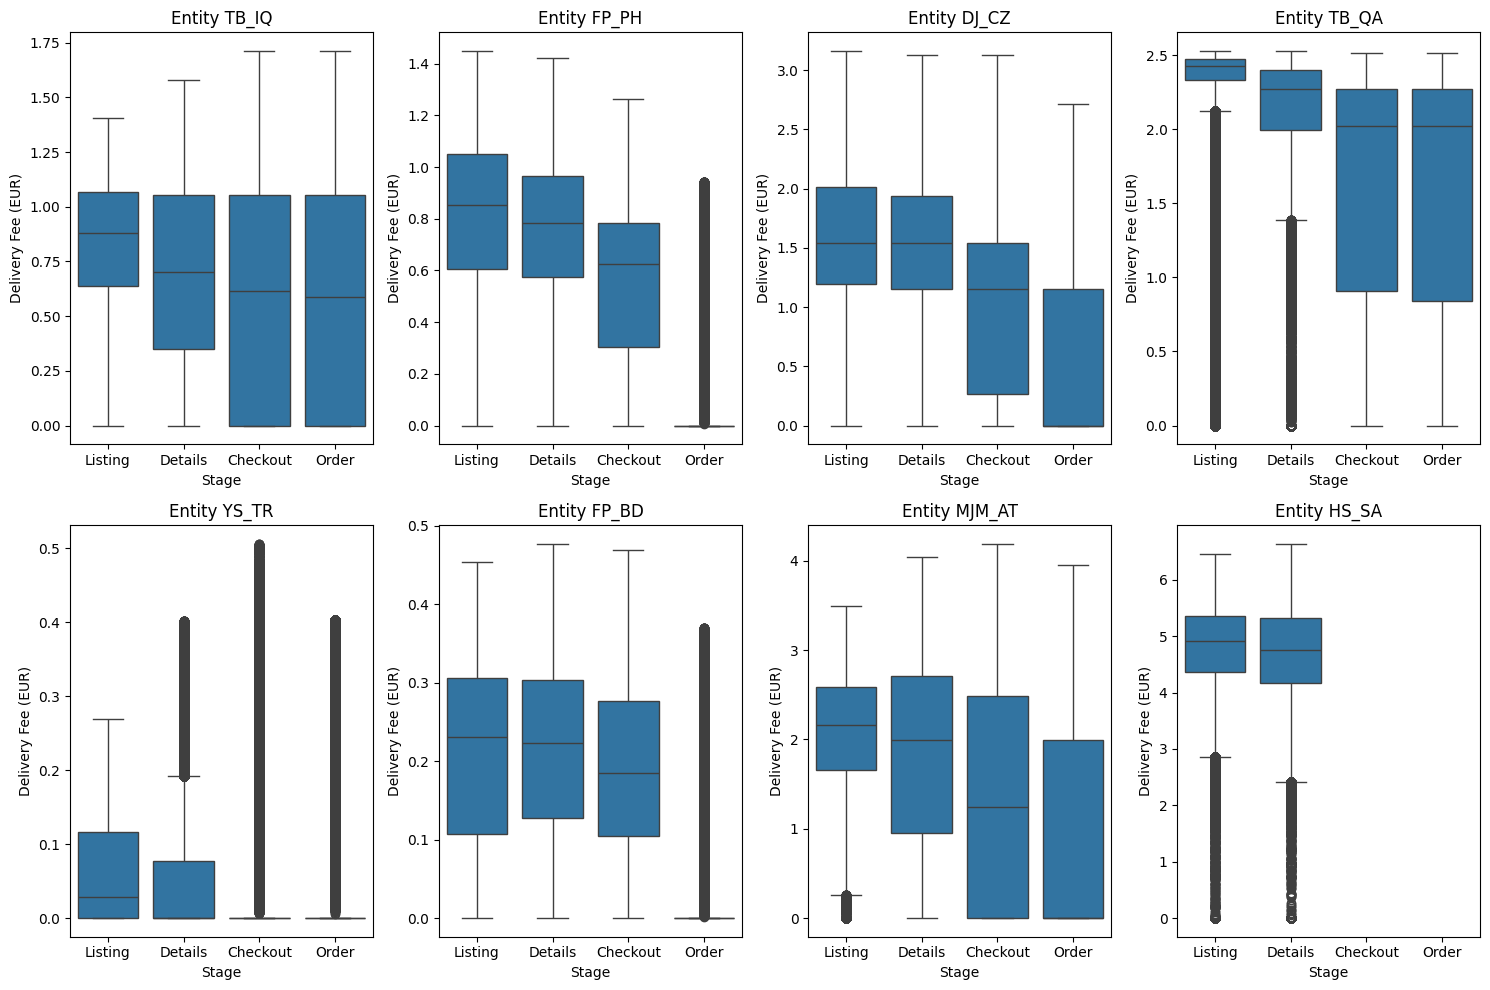

In [61]:
column_list = ['delivery_fee_listing_eur_mean', 'delivery_fee_details_eur_mean', 'delivery_fee_checkout_eur_mean', 'delivery_fee_order_eur_mean']
plot_ch(user_summary_df, column_list)

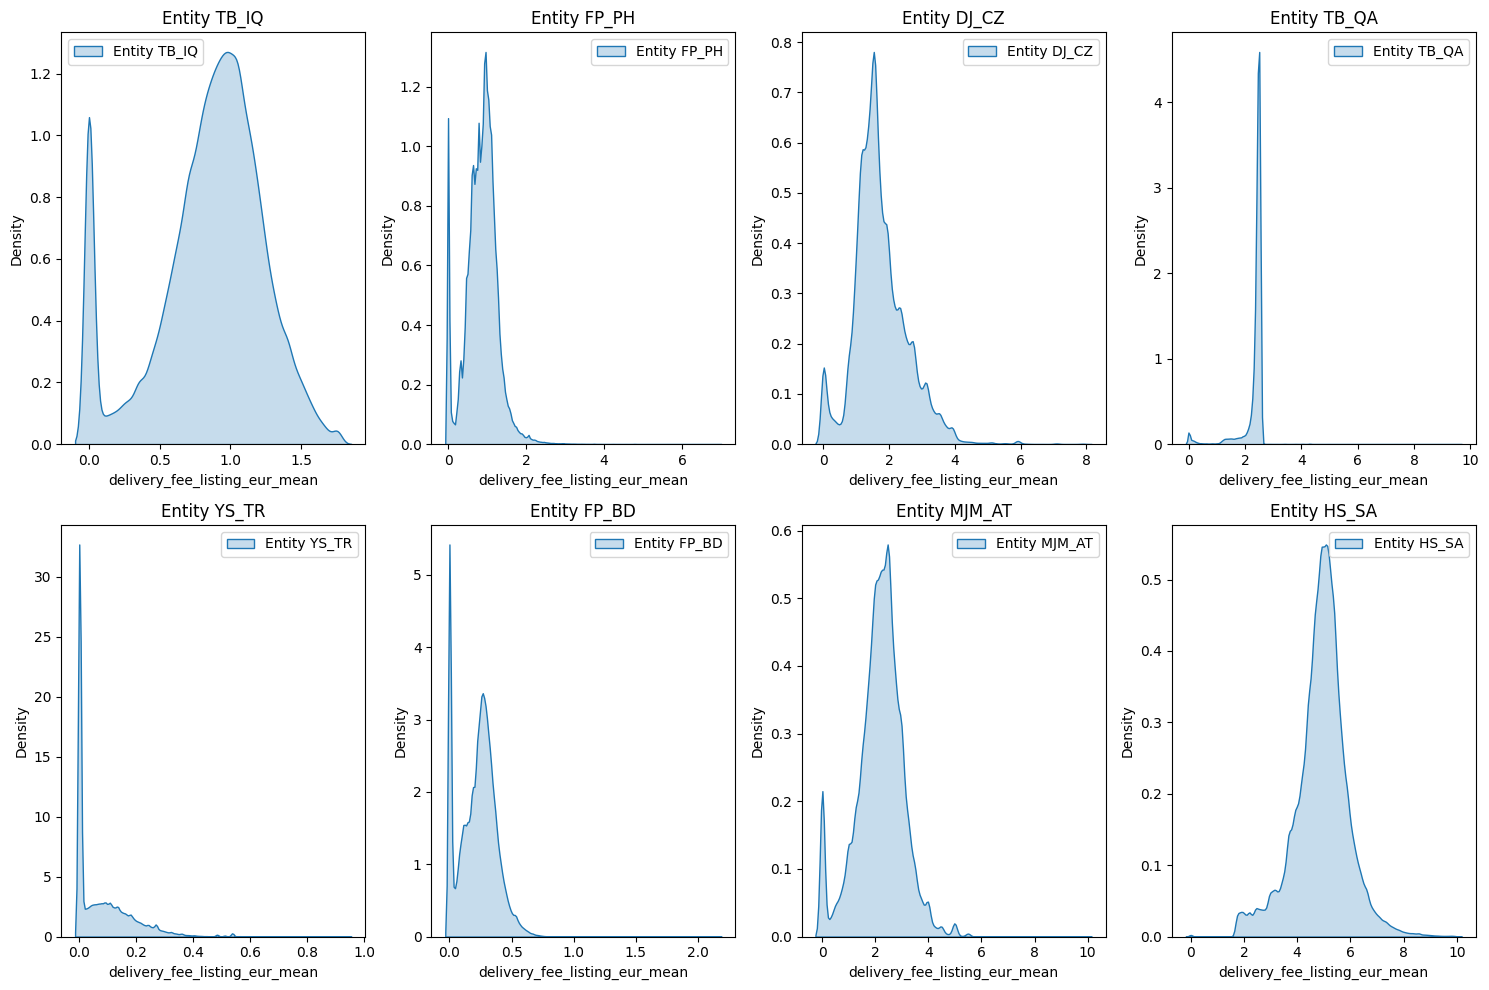

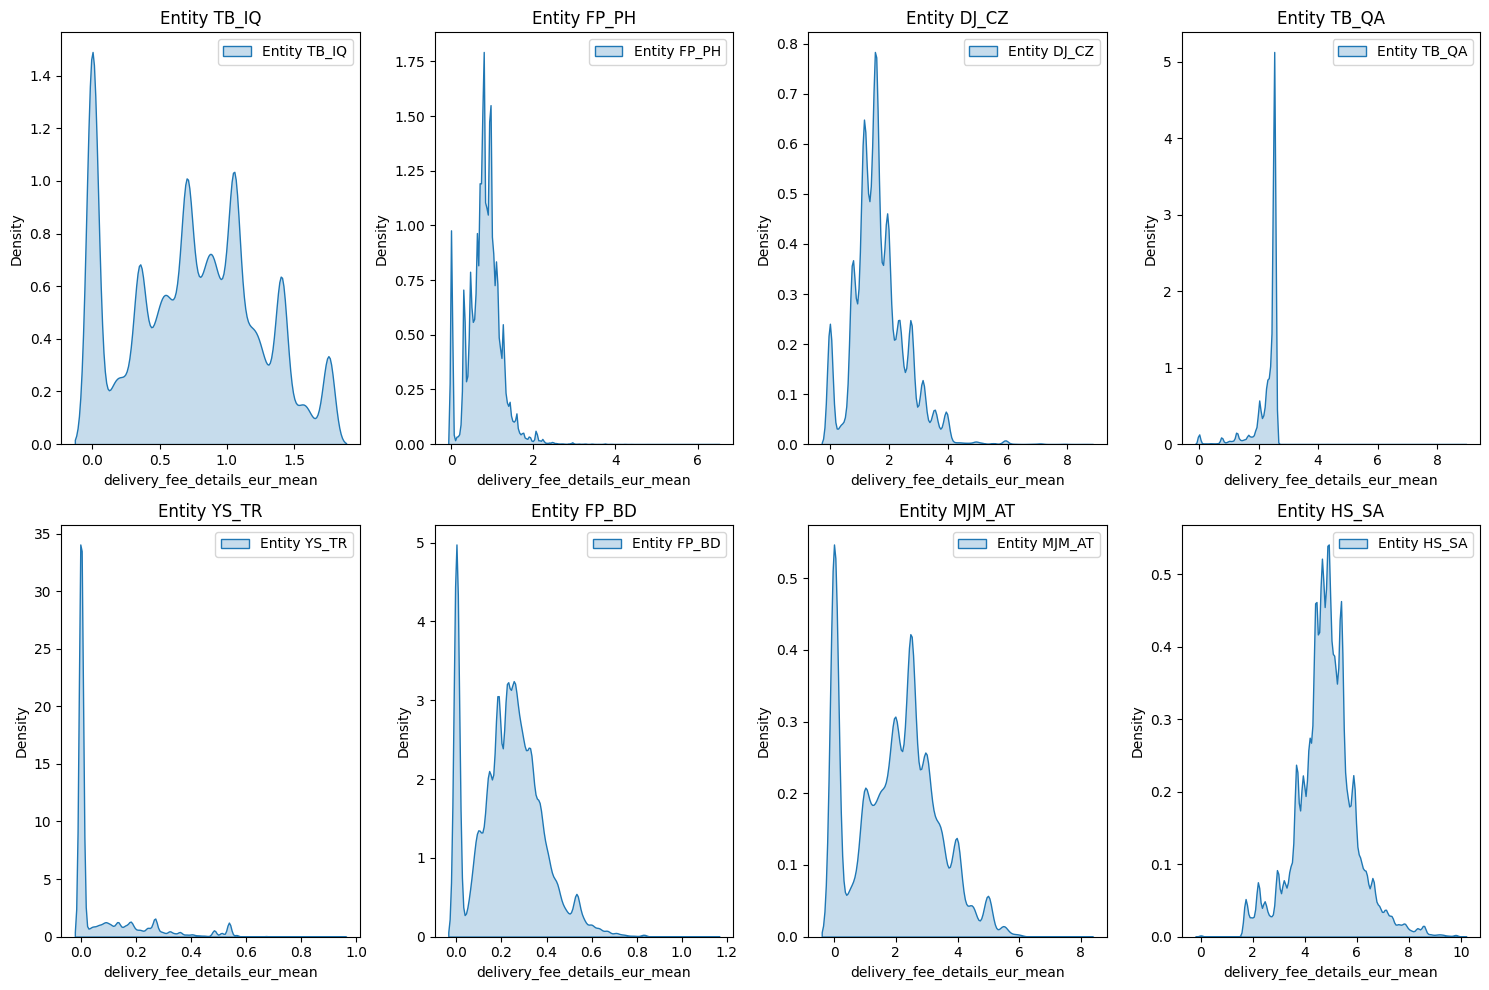

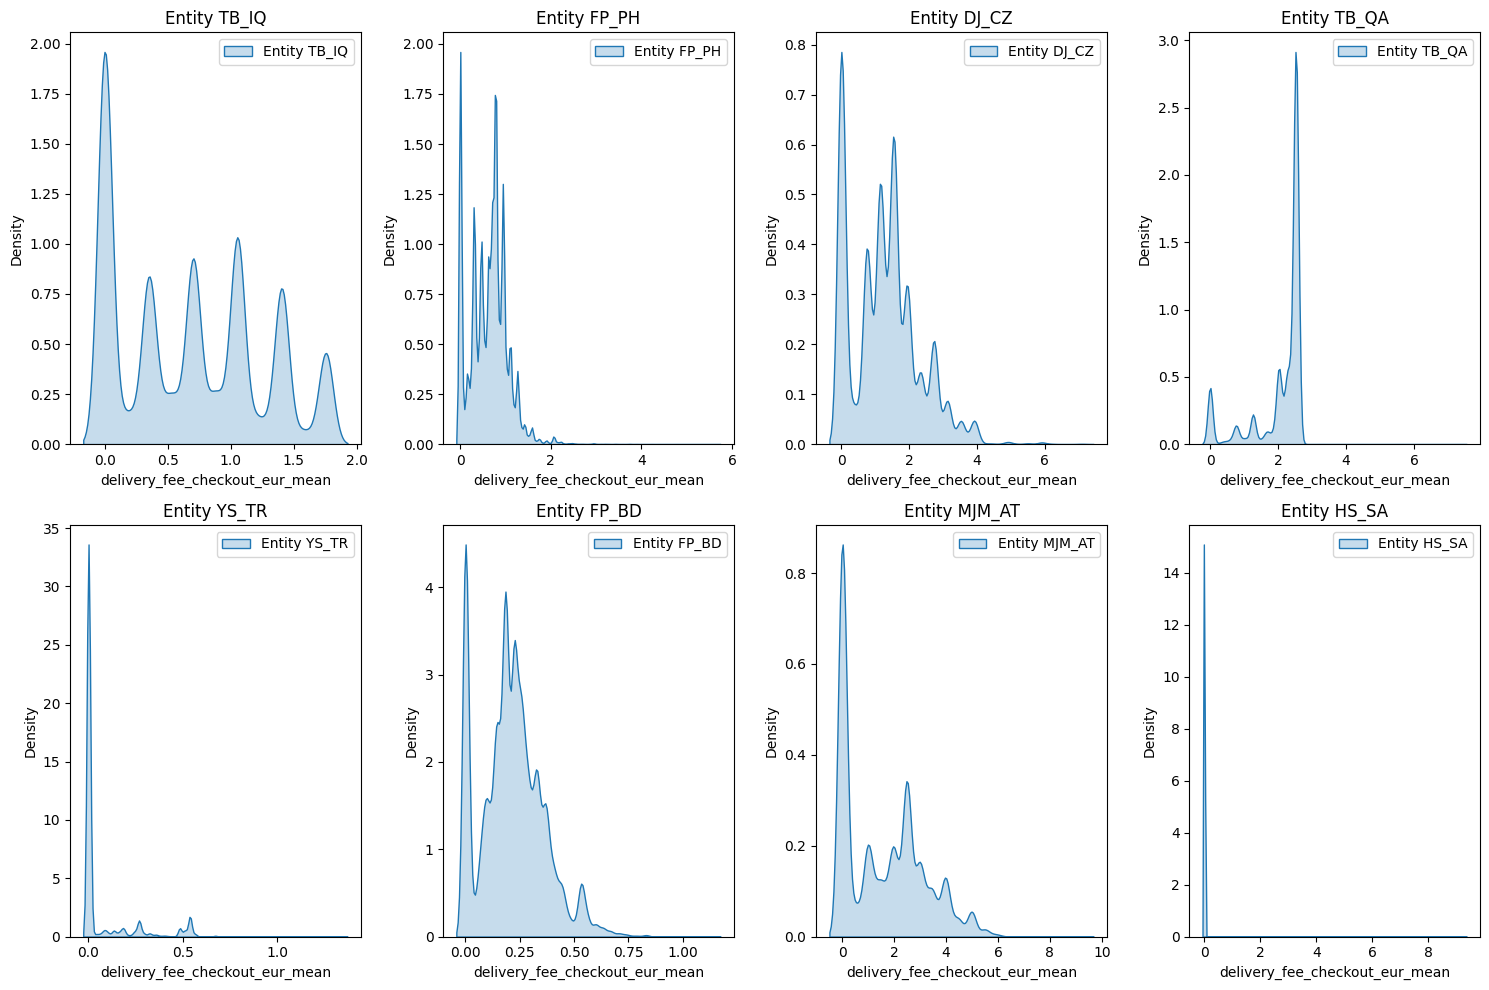

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1656532637.py:39: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1656532637.py:43: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



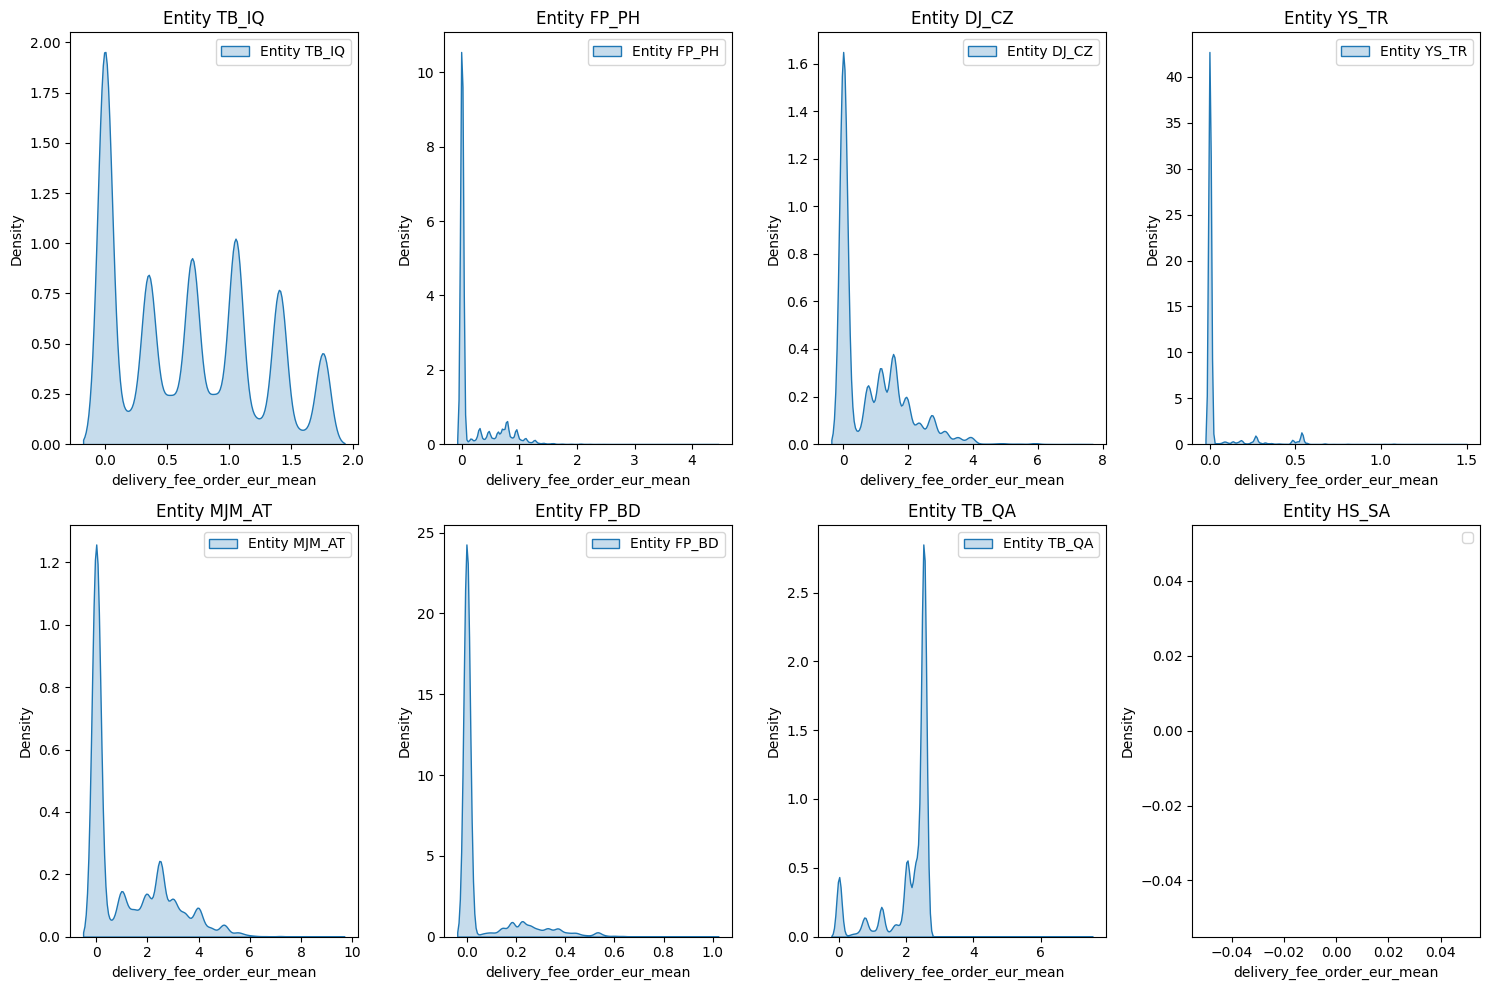

In [52]:
plot_entity_kde(user_summary_df, 'delivery_fee_listing_eur_mean')
plot_entity_kde(user_summary_df, 'delivery_fee_details_eur_mean')
plot_entity_kde(user_summary_df, 'delivery_fee_checkout_eur_mean')
plot_entity_kde(user_summary_df, 'delivery_fee_order_eur_mean')

In [30]:
descriptive_stats(user_summary_df)

Group: DJ_CZ


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"109,722.00",1.72,0.81,0.00,1.22,1.58,2.14,7.92
delivery_fee_details_eur_mean,"86,021.00",1.65,0.87,0.00,1.15,1.55,2.05,8.60
delivery_fee_checkout_eur_mean,"44,009.00",1.26,1.00,0.00,0.38,1.15,1.94,7.09
delivery_fee_order_eur_mean,"40,431.00",0.82,1.02,0.00,0.00,0.00,1.55,7.33
delivery_fee_listing_eur_median,"109,722.00",1.64,0.92,0.00,1.15,1.55,1.94,7.92
delivery_fee_details_eur_median,"86,021.00",1.55,0.93,0.00,1.15,1.55,1.94,8.60
delivery_fee_checkout_eur_median,"44,009.00",1.21,1.00,0.00,0.00,1.15,1.55,7.09
delivery_fee_order_eur_median,"40,431.00",0.79,1.01,0.00,0.00,0.00,1.55,7.33
delivery_fee_listing_eur_min,"109,722.00",0.81,0.85,0.00,0.00,0.75,1.15,7.92
delivery_fee_details_eur_min,"86,021.00",1.27,0.93,0.00,0.75,1.15,1.55,8.60


Group: FP_BD


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"360,369.00",0.22,0.14,0.00,0.12,0.24,0.32,2.16
delivery_fee_details_eur_mean,"280,678.00",0.23,0.15,0.00,0.14,0.23,0.32,1.13
delivery_fee_checkout_eur_mean,"119,252.00",0.21,0.15,0.00,0.11,0.21,0.30,1.13
delivery_fee_order_eur_mean,"103,275.00",0.06,0.13,0.00,0.00,0.00,0.00,0.99
delivery_fee_listing_eur_median,"360,369.00",0.21,0.15,0.00,0.09,0.22,0.32,2.16
delivery_fee_details_eur_median,"280,678.00",0.21,0.15,0.00,0.11,0.21,0.30,1.13
delivery_fee_checkout_eur_median,"119,252.00",0.20,0.15,0.00,0.10,0.18,0.28,1.13
delivery_fee_order_eur_median,"103,275.00",0.06,0.13,0.00,0.00,0.00,0.00,0.99
delivery_fee_listing_eur_min,"360,369.00",0.11,0.12,0.00,0.00,0.11,0.18,2.16
delivery_fee_details_eur_min,"280,678.00",0.18,0.13,0.00,0.08,0.18,0.25,1.13


Group: FP_PH


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"1,662,697.00",0.85,0.41,0.00,0.62,0.87,1.09,6.94
delivery_fee_details_eur_mean,"1,302,122.00",0.81,0.40,0.00,0.60,0.78,1.01,6.46
delivery_fee_checkout_eur_mean,"641,786.00",0.62,0.41,0.00,0.30,0.66,0.86,5.66
delivery_fee_order_eur_mean,"551,938.00",0.20,0.36,0.00,0.00,0.00,0.30,4.38
delivery_fee_listing_eur_median,"1,662,697.00",0.79,0.41,0.00,0.62,0.78,0.99,6.94
delivery_fee_details_eur_median,"1,302,122.00",0.76,0.39,0.00,0.54,0.78,0.94,6.46
delivery_fee_checkout_eur_median,"641,786.00",0.59,0.41,0.00,0.30,0.62,0.84,5.66
delivery_fee_order_eur_median,"551,938.00",0.19,0.36,0.00,0.00,0.00,0.24,4.38
delivery_fee_listing_eur_min,"1,662,697.00",0.52,0.35,0.00,0.30,0.62,0.75,6.94
delivery_fee_details_eur_min,"1,302,122.00",0.68,0.37,0.00,0.46,0.70,0.86,6.46


Group: HS_SA


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"1,185,344.00",4.89,1.04,0.00,4.41,4.96,5.44,11.02
delivery_fee_details_eur_mean,"975,884.00",4.82,1.17,0.00,4.23,4.82,5.39,11.02
delivery_fee_checkout_eur_mean,"581,164.00",0.02,0.29,0.00,0.00,0.00,0.00,11.02
delivery_fee_order_eur_mean,"468,952.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
delivery_fee_listing_eur_median,"1,185,344.00",4.72,1.06,0.00,4.16,4.90,5.39,11.02
delivery_fee_details_eur_median,"975,884.00",4.64,1.18,0.00,4.16,4.65,5.39,11.02
delivery_fee_checkout_eur_median,"581,164.00",0.01,0.26,0.00,0.00,0.00,0.00,11.02
delivery_fee_order_eur_median,"468,952.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
delivery_fee_listing_eur_min,"1,185,344.00",3.43,0.83,0.00,2.94,3.67,3.67,11.02
delivery_fee_details_eur_min,"975,884.00",4.10,1.13,0.00,3.67,4.16,4.65,11.02


Group: MJM_AT


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"126,028.00",2.15,0.88,0.00,1.69,2.22,2.68,9.90
delivery_fee_details_eur_mean,"99,294.00",1.97,1.34,0.00,0.99,2.00,2.90,10.00
delivery_fee_checkout_eur_mean,"63,485.00",1.58,1.52,0.00,0.00,1.49,2.49,10.00
delivery_fee_order_eur_mean,"58,714.00",1.17,1.52,0.00,0.00,0.00,2.49,9.19
delivery_fee_listing_eur_median,"126,028.00",2.09,1.19,0.00,1.49,2.49,2.49,9.90
delivery_fee_details_eur_median,"99,294.00",1.77,1.51,0.00,0.00,1.99,2.99,10.00
delivery_fee_checkout_eur_median,"63,485.00",1.44,1.56,0.00,0.00,0.99,2.49,10.00
delivery_fee_order_eur_median,"58,714.00",1.08,1.52,0.00,0.00,0.00,2.49,9.19
delivery_fee_listing_eur_min,"126,028.00",0.39,0.94,0.00,0.00,0.00,0.00,9.90
delivery_fee_details_eur_min,"99,294.00",1.19,1.47,0.00,0.00,0.00,2.49,10.00


Group: TB_IQ


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"238,726.00",0.85,0.39,0.00,0.66,0.90,1.10,1.76
delivery_fee_details_eur_mean,"193,468.00",0.74,0.49,0.00,0.35,0.72,1.05,1.76
delivery_fee_checkout_eur_mean,"95,699.00",0.67,0.57,0.00,0.00,0.70,1.05,1.76
delivery_fee_order_eur_mean,"89,119.00",0.67,0.57,0.00,0.00,0.70,1.05,1.76
delivery_fee_listing_eur_median,"238,726.00",0.90,0.53,0.00,0.70,1.05,1.40,1.76
delivery_fee_details_eur_median,"193,468.00",0.68,0.59,0.00,0.00,0.70,1.05,1.76
delivery_fee_checkout_eur_median,"95,699.00",0.62,0.59,0.00,0.00,0.70,1.05,1.76
delivery_fee_order_eur_median,"89,119.00",0.62,0.59,0.00,0.00,0.35,1.05,1.76
delivery_fee_listing_eur_min,"238,726.00",0.06,0.23,0.00,0.00,0.00,0.00,1.76
delivery_fee_details_eur_min,"193,468.00",0.36,0.53,0.00,0.00,0.00,0.70,1.76


Group: TB_QA


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"231,983.00",2.33,1.74,0.00,2.37,2.45,2.50,505.51
delivery_fee_details_eur_mean,"172,657.00",2.29,1.32,0.00,2.27,2.51,2.53,505.51
delivery_fee_checkout_eur_mean,"112,991.00",2.07,0.76,0.00,2.02,2.53,2.53,7.33
delivery_fee_order_eur_mean,"108,749.00",2.06,0.77,0.00,2.02,2.53,2.53,7.33
delivery_fee_listing_eur_median,"231,983.00",2.42,1.76,0.00,2.53,2.53,2.53,505.51
delivery_fee_details_eur_median,"172,657.00",2.30,1.32,0.00,2.53,2.53,2.53,505.51
delivery_fee_checkout_eur_median,"112,991.00",2.03,0.85,0.00,2.02,2.53,2.53,7.33
delivery_fee_order_eur_median,"108,749.00",2.02,0.86,0.00,2.02,2.53,2.53,7.33
delivery_fee_listing_eur_min,"231,983.00",1.21,1.19,0.00,0.76,1.26,2.02,252.75
delivery_fee_details_eur_min,"172,657.00",1.95,1.45,0.00,1.26,2.27,2.53,505.51


Group: YS_TR


,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
delivery_fee_listing_eur_mean,"2,768,638.00",0.08,0.10,0.00,0.00,0.04,0.13,0.94
delivery_fee_details_eur_mean,"2,164,191.00",0.08,0.14,0.00,0.00,0.00,0.11,0.94
delivery_fee_checkout_eur_mean,"1,269,567.00",0.07,0.15,0.00,0.00,0.00,0.00,1.34
delivery_fee_order_eur_mean,"1,152,284.00",0.04,0.13,0.00,0.00,0.00,0.00,1.48
delivery_fee_listing_eur_median,"2,768,638.00",0.03,0.11,0.00,0.00,0.00,0.00,0.94
delivery_fee_details_eur_median,"2,164,191.00",0.05,0.14,0.00,0.00,0.00,0.00,0.94
delivery_fee_checkout_eur_median,"1,269,567.00",0.05,0.15,0.00,0.00,0.00,0.00,1.34
delivery_fee_order_eur_median,"1,152,284.00",0.03,0.13,0.00,0.00,0.00,0.00,1.48
delivery_fee_listing_eur_min,"2,768,638.00",0.00,0.05,0.00,0.00,0.00,0.00,0.94
delivery_fee_details_eur_min,"2,164,191.00",0.03,0.11,0.00,0.00,0.00,0.00,0.94


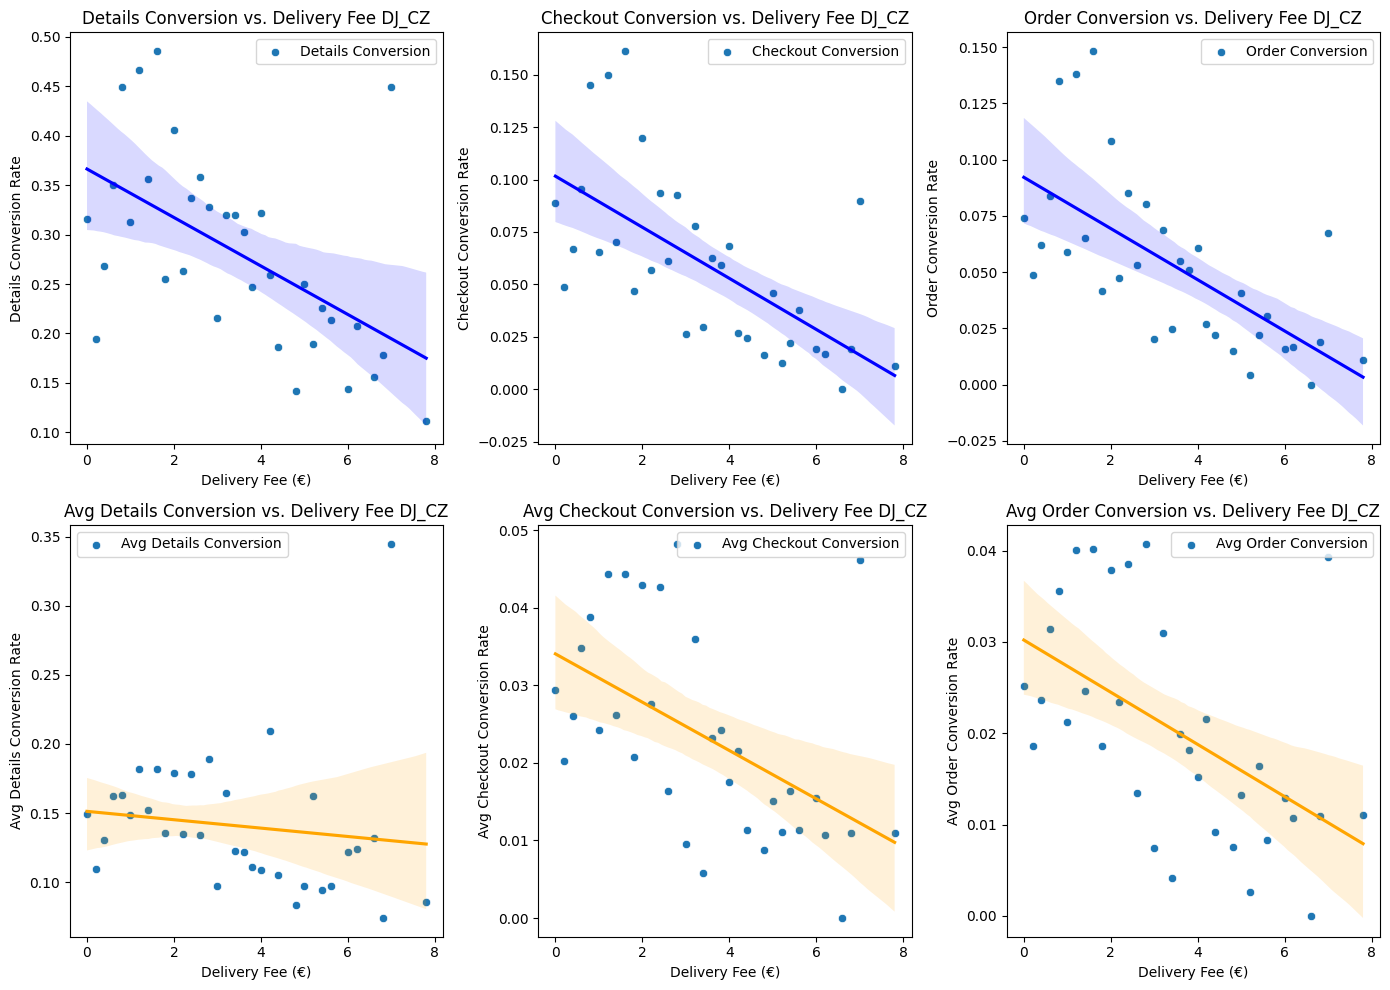

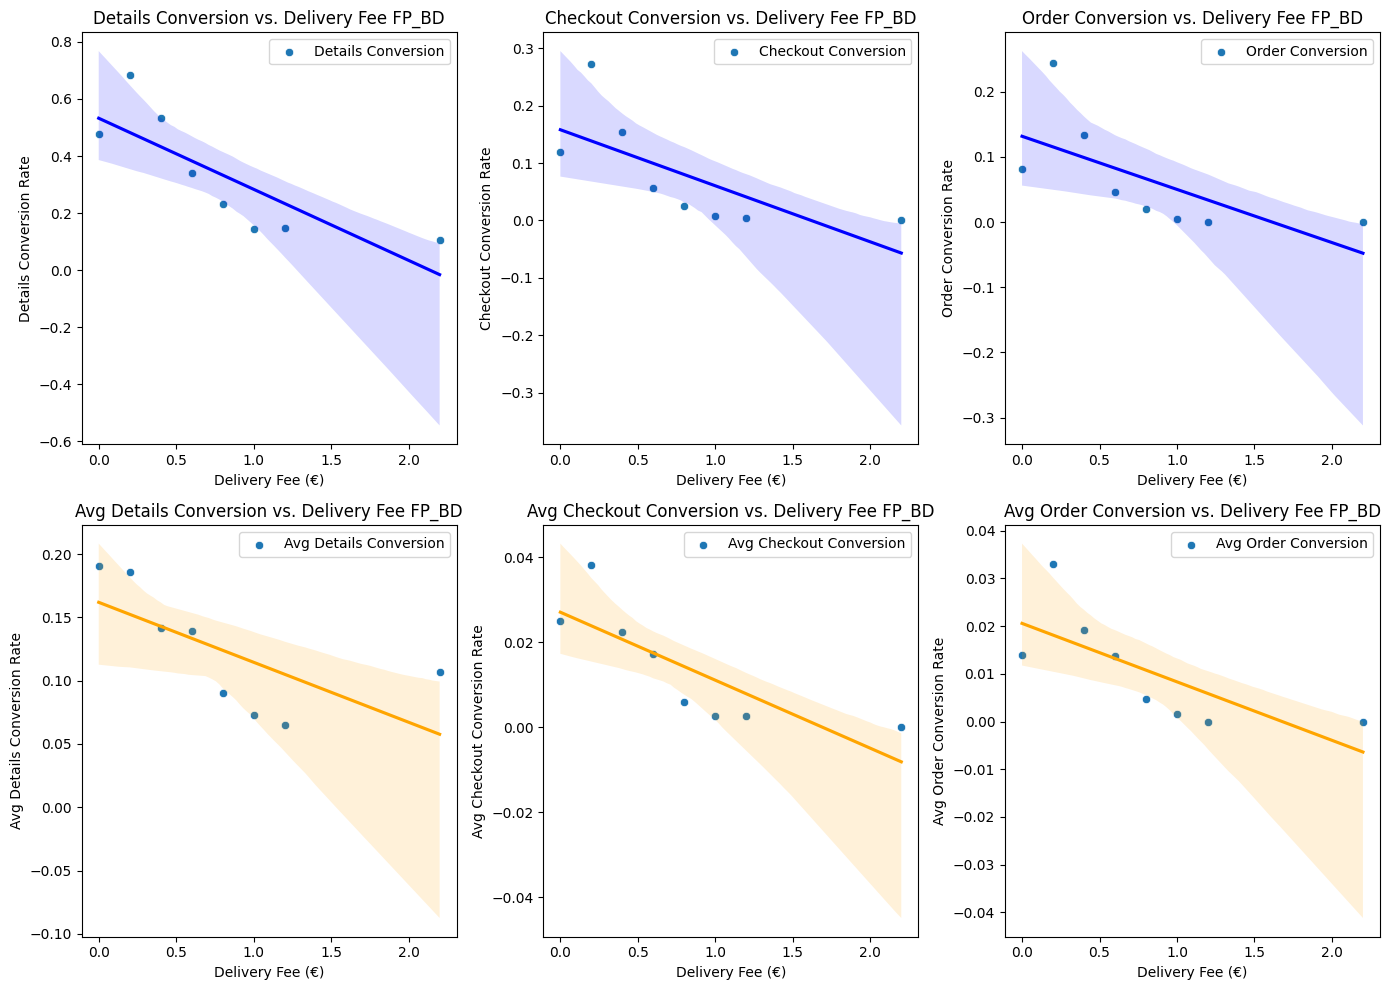

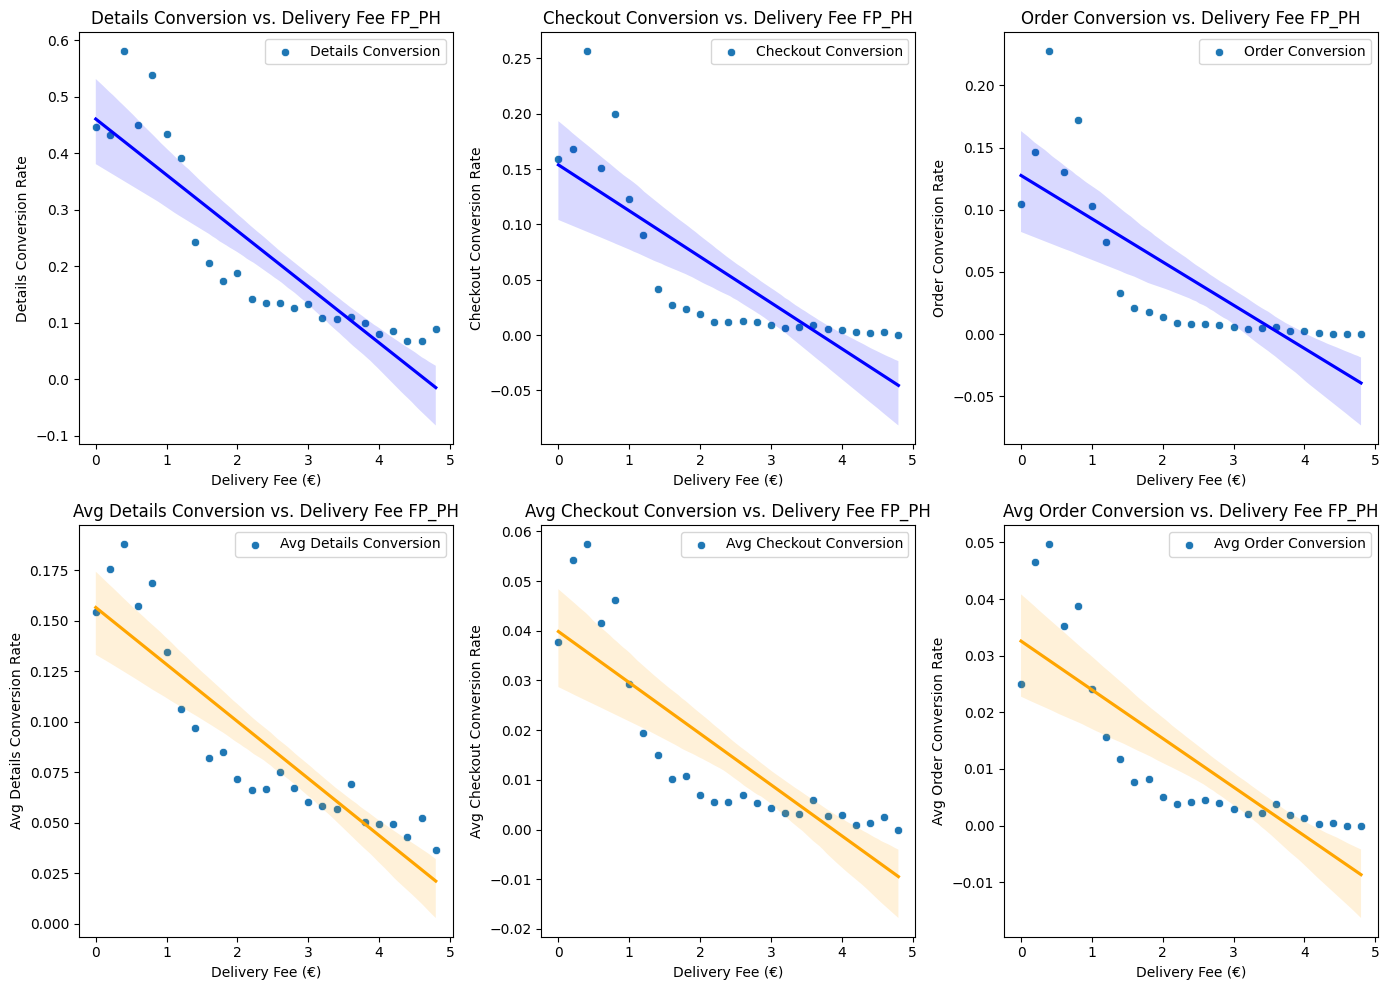

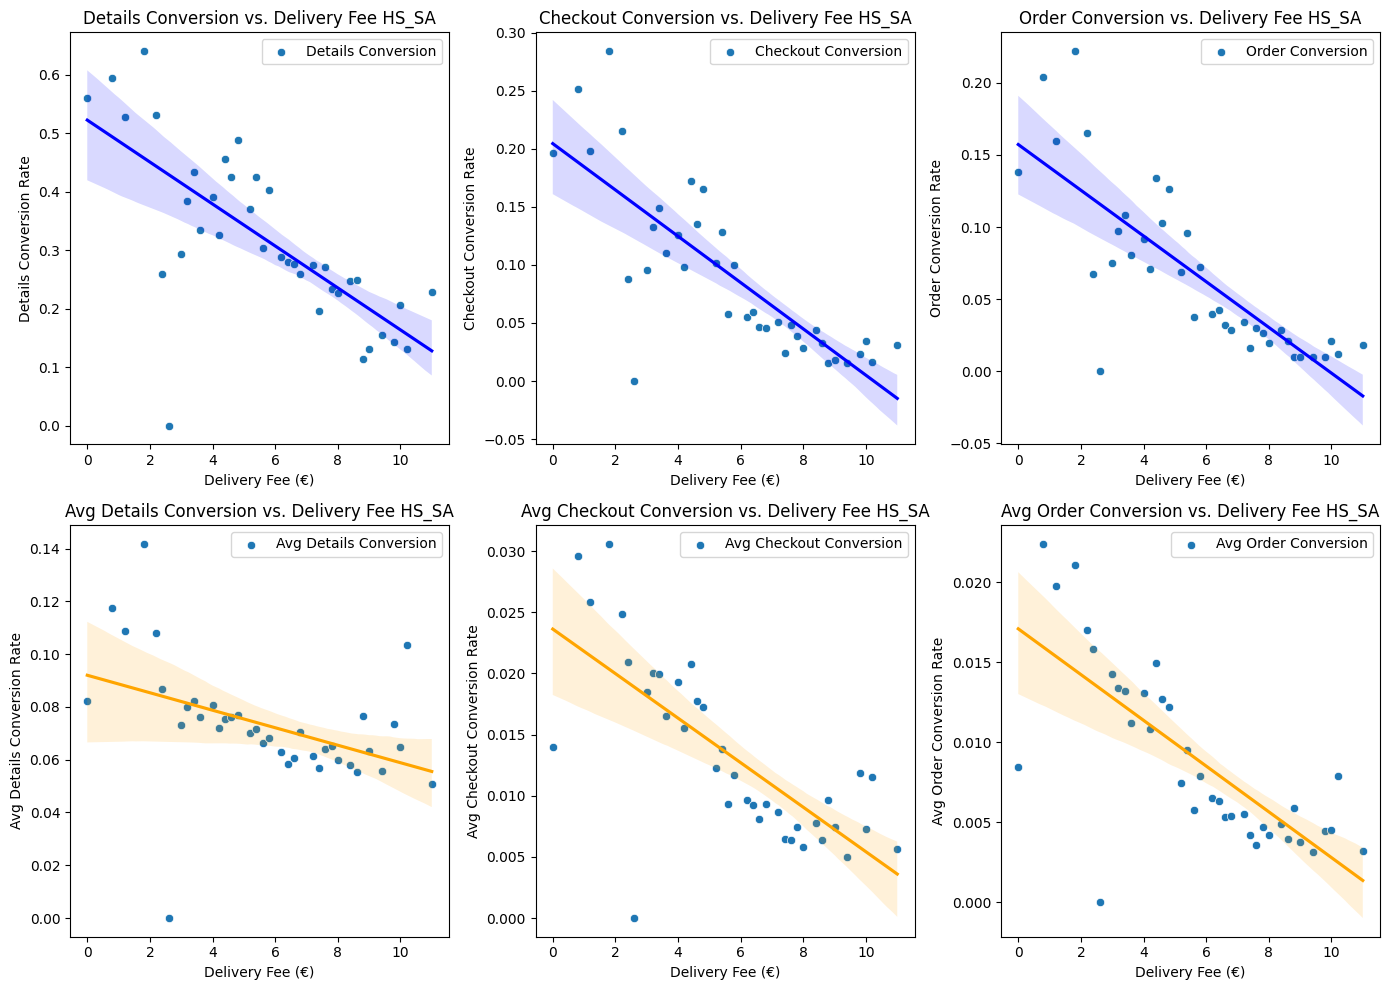

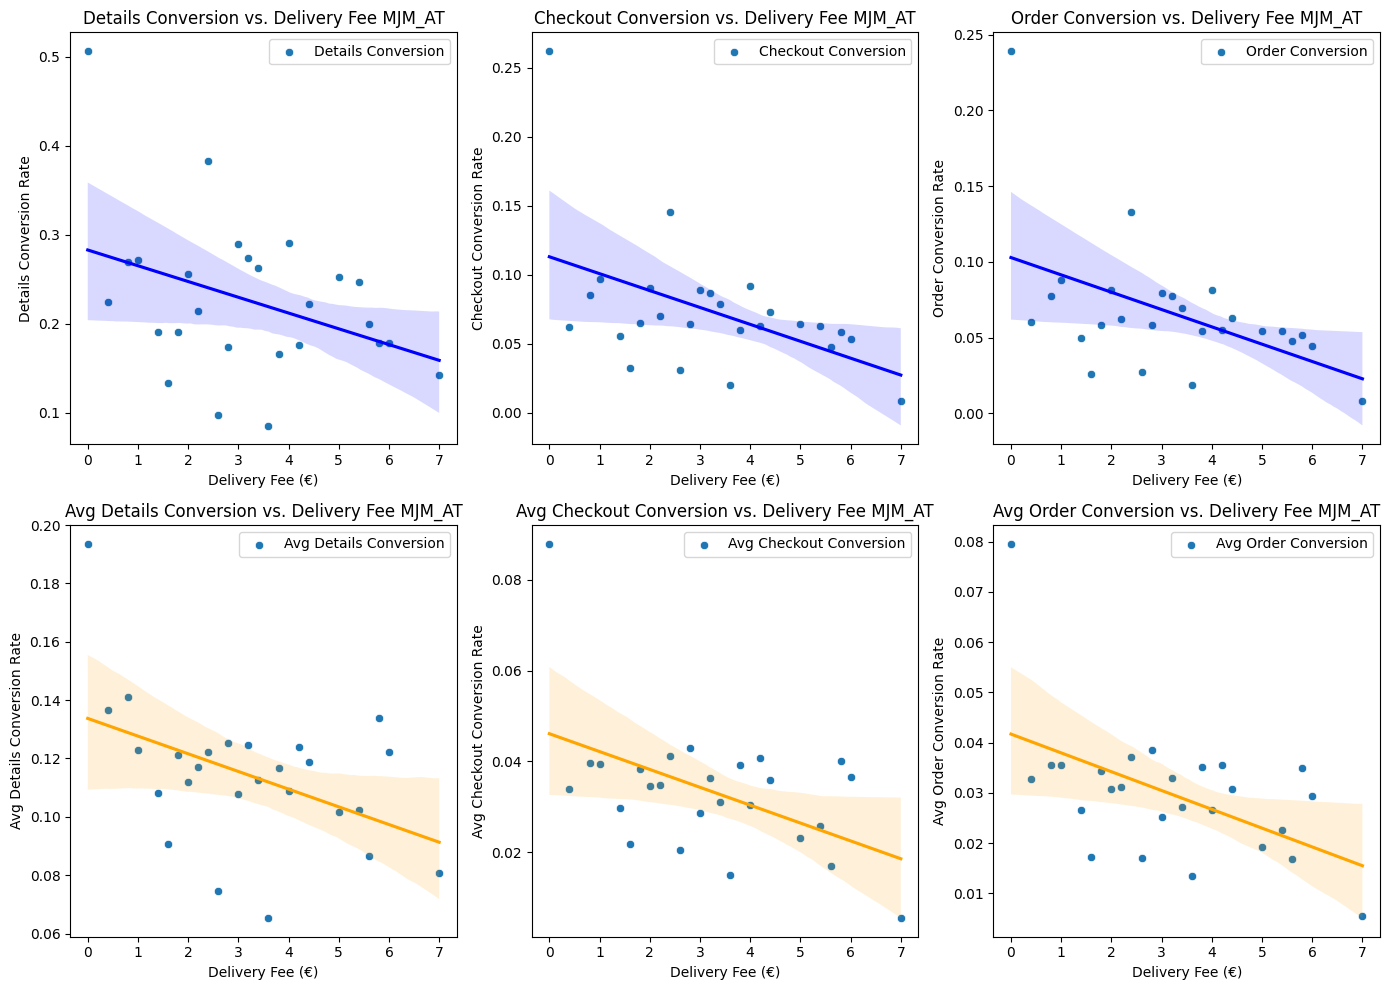

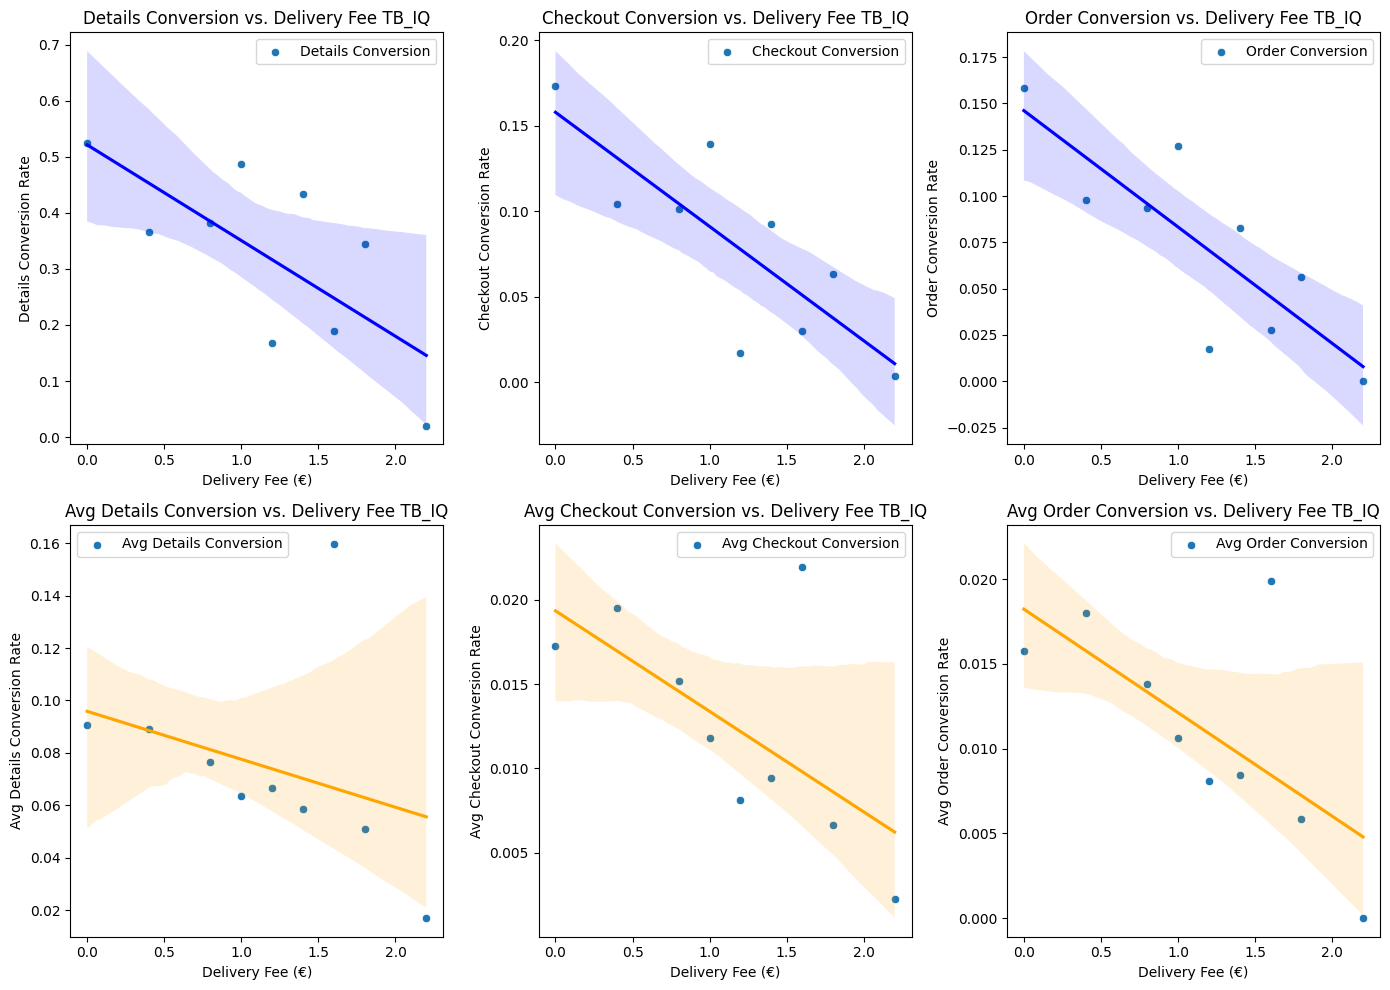

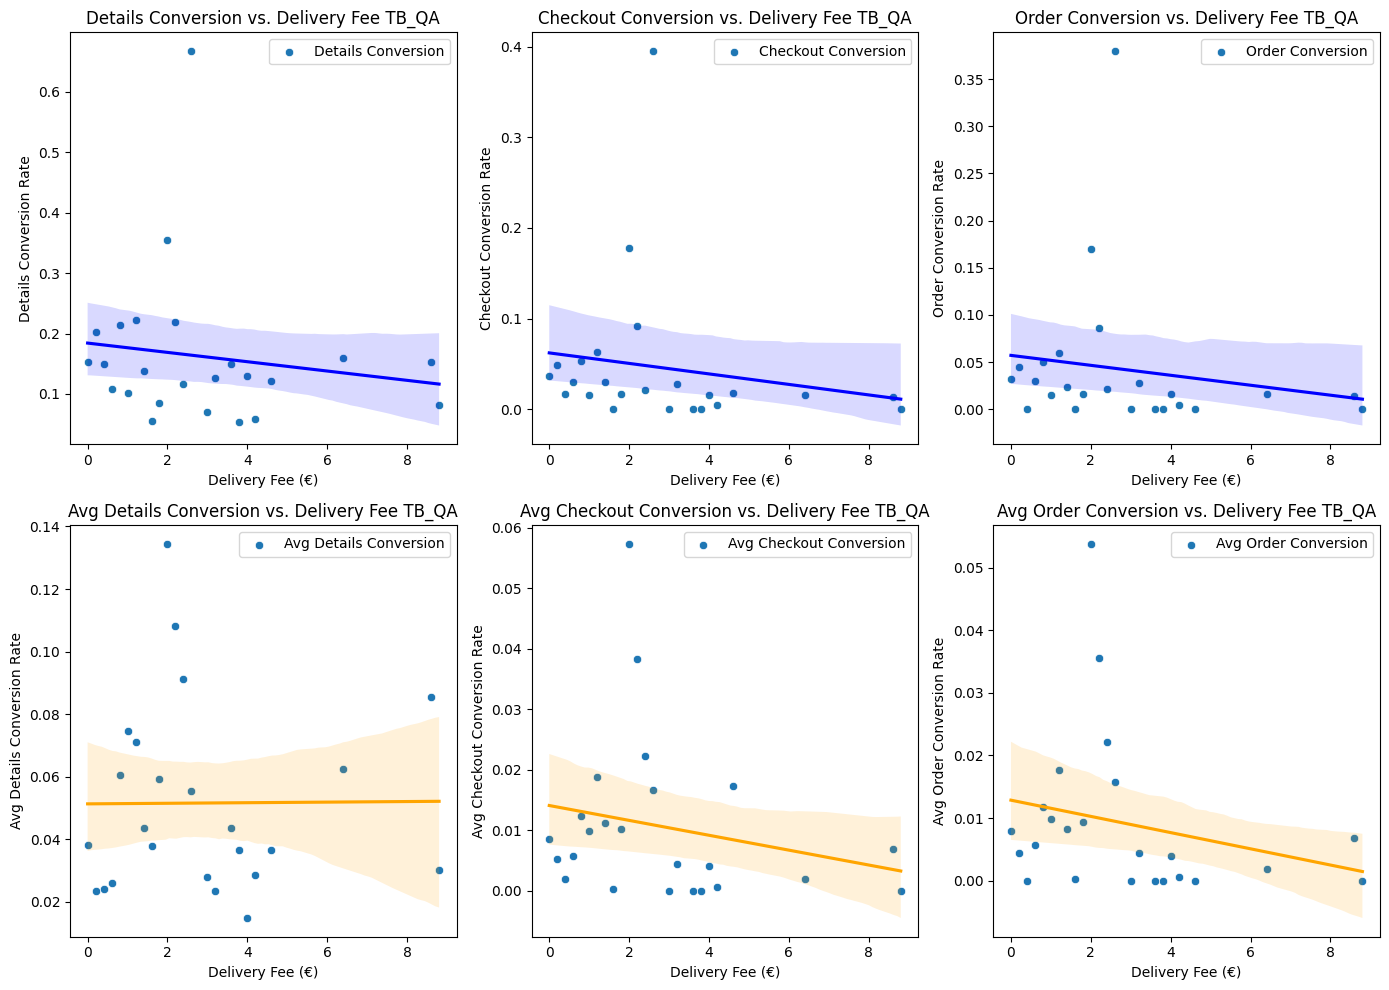

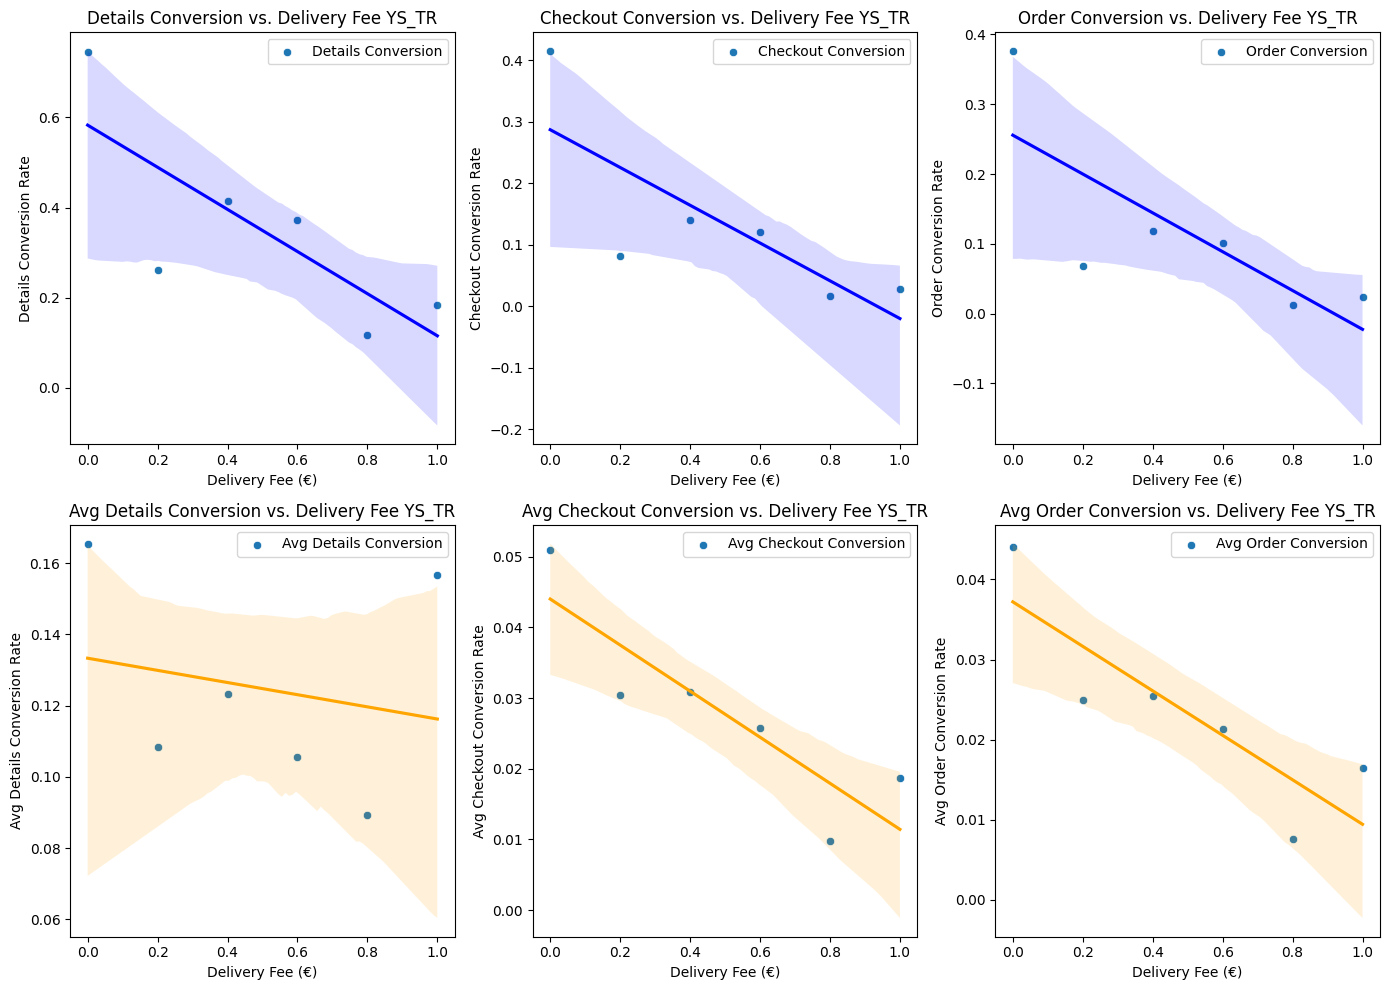

In [122]:
plot_conversion(user_conversion_df)

In [105]:
# Initialize a DataFrame to store the elasticity coefficients for each y variable
elasticity_df = pd.DataFrame(columns=['global_entity_id', 'avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order'])

# List of dependent variables (y variables)
dependent_vars = ['avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order']

# Loop through each unique global_entity_id
for i in user_conversion_df['global_entity_id'].unique():
    
    # Filter data for the current entity
    user_df_clean = user_conversion_df[user_conversion_df['global_entity_id'] == i]
    
    # Apply log transformation to delivery_fee and the dependent variables
    user_df_clean['log_delivery_fee'] = np.log(user_df_clean['delivery_fee_listing'] + 1)  # Avoiding log(0)

    # Initialize a dictionary to store the entity ID and coefficients for each y variable
    elasticity_row = {'global_entity_id': i}
    
    # Loop through each dependent variable
    for dep_var in dependent_vars:
        # Apply log transformation to the dependent variable
        user_df_clean[dep_var] = np.log(user_df_clean[dep_var.replace('log_', '')] + 1)  # Avoiding log(0) for the original non-log variable

        # Add a constant column (intercept)
        user_df_clean['constant'] = np.ones(len(user_df_clean), dtype=float)

        # Ensure the dtype is numeric for the log-transformed columns
        user_df_clean[['log_delivery_fee', dep_var]] = user_df_clean[['log_delivery_fee', dep_var]].astype(float)

        # Set up the regression model with both the constant and the log-transformed delivery fee
        X_log = user_df_clean[['constant', 'log_delivery_fee']]

        # Fit the log-linear regression model
        model_log = sm.OLS(user_df_clean[dep_var], X_log).fit()

        # Store the elasticity coefficient (slope of log_delivery_fee) in the dictionary for the current dependent variable
        elasticity_row[dep_var] = model_log.params['log_delivery_fee']
    
    # Add the row to elasticity_df
    elasticity_df = pd.concat([elasticity_df, pd.DataFrame([elasticity_row])], ignore_index=True)

elasticity_df

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1469021112.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1469021112.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1469021112.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,global_entity_id,avg_conversion_details,avg_conversion_checkout,avg_conversion_order
0,DJ_CZ,-0.010832,-0.010564,-0.009882
1,FP_BD,-0.091896,-0.031594,-0.023907
2,FP_PH,-0.077428,-0.031287,-0.026086
3,HS_SA,-0.017412,-0.008891,-0.006941
4,MJM_AT,-0.024011,-0.015626,-0.014941
5,TB_IQ,-0.030022,-0.010577,-0.010700
6,TB_QA,0.002900,-0.002809,-0.003319
7,YS_TR,-0.029985,-0.046984,-0.040440


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1383488020.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1383488020.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_72239/1383488020.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

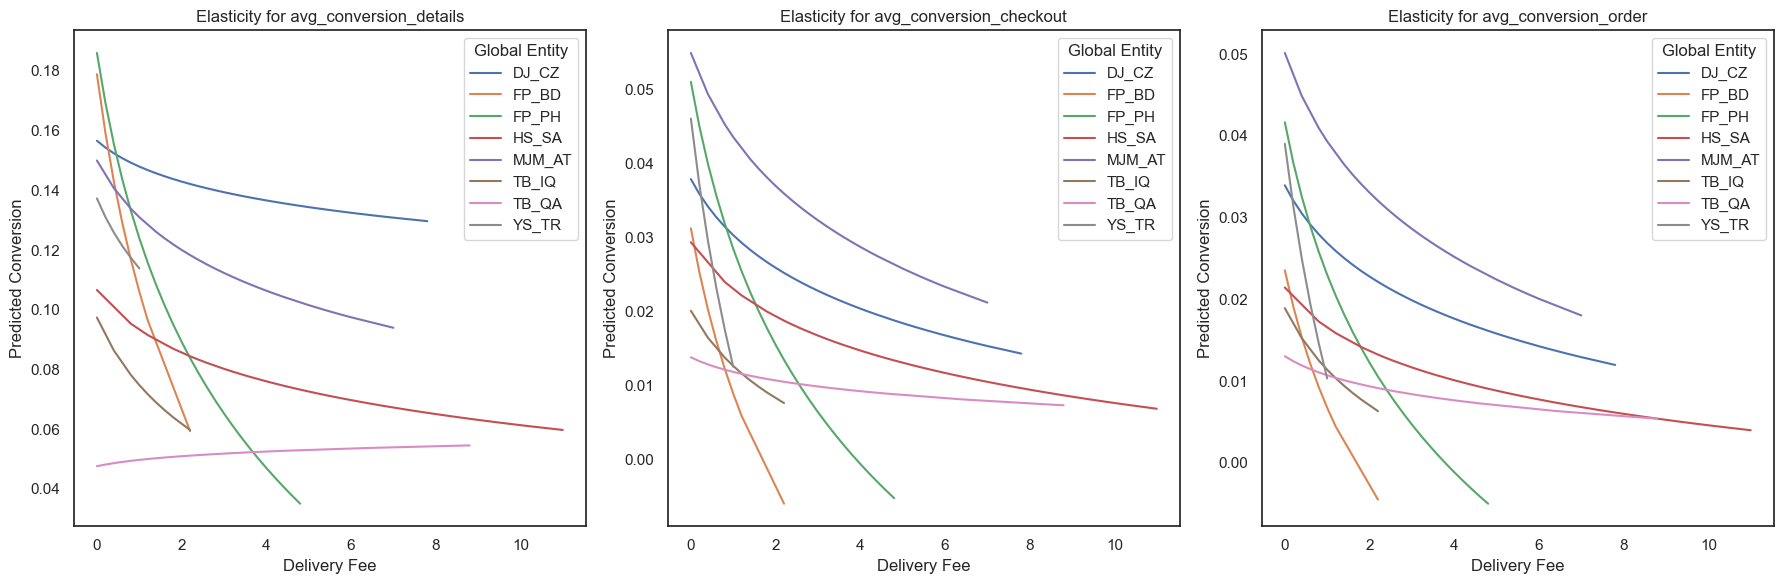

In [125]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Set the Seaborn theme
sns.set_theme(style="white")  # This removes the gridlines

# Set up the figure and axes for 3 subplots, one for each dependent variable
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each dependent variable (conversion stage)
for idx, dep_var in enumerate(dependent_vars):
    ax = axes[idx]  # Select the subplot

    # Loop through each entity and plot the elasticity line
    for entity in elasticity_df['global_entity_id'].unique():
        # Filter data for the current entity
        user_df_clean = user_conversion_df[user_conversion_df['global_entity_id'] == entity]

        # Apply log transformation to delivery fee and dependent variable
        user_df_clean['log_delivery_fee'] = np.log(user_df_clean['delivery_fee_listing'] + 1)  # Avoid log(0)
        user_df_clean[dep_var] = np.log(user_df_clean[dep_var.replace('log_', '')] + 1)  # Avoid log(0)

        # Add a constant column (intercept)
        user_df_clean['constant'] = np.ones(len(user_df_clean), dtype=float)

        # Set up the regression model
        X_log = user_df_clean[['constant', 'log_delivery_fee']]

        # Fit the model
        model_log = sm.OLS(user_df_clean[dep_var], X_log).fit()

        # Generate predicted conversion values using the model
        predicted_conversion = model_log.predict(X_log)

        # Reverse the log transformation for plotting purposes
        actual_delivery_fees = np.exp(user_df_clean['log_delivery_fee']) - 1
        predicted_conversion = np.exp(predicted_conversion) - 1

        # Plot actual delivery fees against predicted conversion for the current entity using Seaborn
        sns.lineplot(x=actual_delivery_fees, y=predicted_conversion, ax=ax, label=entity)

    # Set title, labels, and legend for the current plot
    ax.set_title(f'Elasticity for {dep_var}')
    ax.set_xlabel('Delivery Fee')
    ax.set_ylabel('Predicted Conversion')
    ax.legend(title='Global Entity')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
